In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,pickle
import neurokit2 as nk
from glob import glob
import math
sns.set_style("whitegrid")

from scipy.signal import find_peaks, welch
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, auc
import matplotlib.pyplot as plt
import random
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)

# Model training: 30s window and 5s shift

Here, we only use the training set: subject 2-13. Among these, we randomly select subjects 13 as hold-out subject for testing. 

The remaining subjects 2-12 are used to train models, with LOSO cross validation

Test subjects: 13

Running LOSO CV on training subjects...

Running LOSO CV on training subjects...


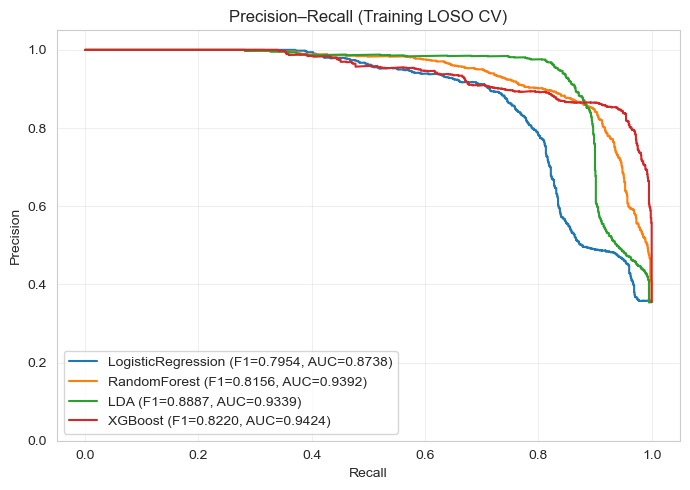

In [78]:
df = pd.read_csv("train_features_c3005.csv")
df = df.dropna(axis=1, how="all")
# Prepare for modeling 
X = df.drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0) # keeping only features
y = df["label"].values.astype(int)
groups = df["subject"].values

subject_ids = sorted(np.unique(groups))

# Train test split
random.seed(42)
test_subjects = random.sample(subject_ids, 1)
train_subjects = [s for s in subject_ids if s not in test_subjects]

print("Test subjects:", test_subjects[0])

# Masks
train_mask = np.isin(groups, train_subjects)
test_mask  = np.isin(groups, test_subjects)

X_train, y_train, groups_train = X[train_mask], y[train_mask], groups[train_mask]
X_test,  y_test,  groups_test  = X[test_mask],  y[test_mask],  groups[test_mask]

# LOSO CV on training subjects only
logo = LeaveOneGroupOut()
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=5000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=500, class_weight="balanced", max_depth=10, random_state=42),
    "LDA": LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"),
    "XGBoost": XGBClassifier(learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,reg_lambda=1.0,random_state=42,objective="binary:logistic")
}

print("\nRunning LOSO CV on training subjects...")
cv_results = {}
plt.figure(figsize=(7,5))
print("\nRunning LOSO CV on training subjects...")
for name, model in models.items():
    y_true_all, y_prob_all = [], []
    for tr, te in logo.split(X_train, y_train, groups_train):
        model.fit(X_train.iloc[tr], y_train[tr])
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_train.iloc[te])[:,1]
        else:
            y_prob = model.decision_function(X_train.iloc[te])
        y_true_all.extend(y_train[te])
        y_prob_all.extend(y_prob)

    y_true_all, y_prob_all = np.array(y_true_all), np.array(y_prob_all)
    precision, recall, _ = precision_recall_curve(y_true_all, y_prob_all)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_true_all, (y_prob_all >= 0.5).astype(int))
    cv_results[name] = {"F1_trainCV": f1, "AUC_PR_trainCV": auc_pr,
                        "precision": precision, "recall": recall}
    plt.plot(recall, precision, label=f"{name} (F1={f1:.4f}, AUC={auc_pr:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (Training LOSO CV)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.ylim(0,1.05)
plt.show()


## Test on subject 13


Testing on hold-out subjects...

======= first 0.5 min =======

=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.98      0.99       231
        TSST       0.17      1.00      0.29         1

    accuracy                           0.98       232
   macro avg       0.58      0.99      0.64       232
weighted avg       1.00      0.98      0.99       232


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       231
        TSST       0.10      1.00      0.18         1

    accuracy                           0.96       232
   macro avg       0.55      0.98      0.58       232
weighted avg       1.00      0.96      0.98       232


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       231
        TSST       1.00      1.00      1.00         1

    accuracy                           1.00       232
 

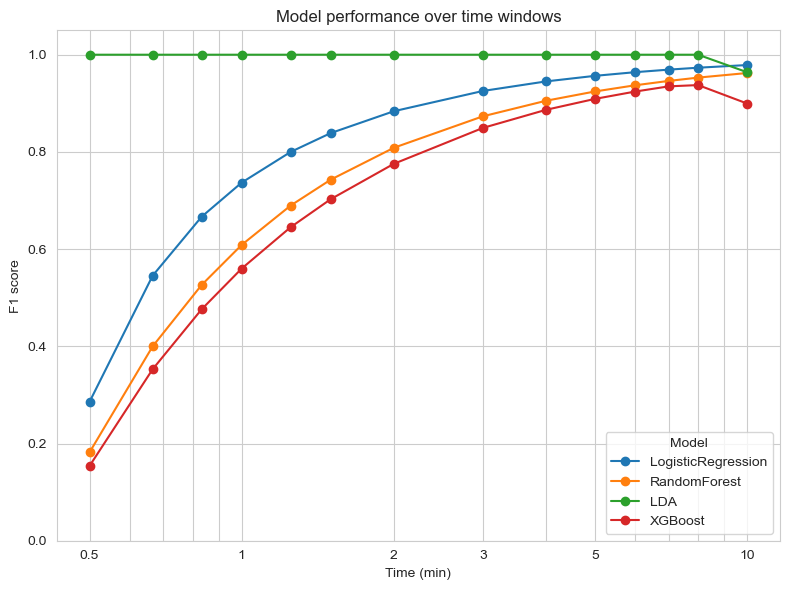

In [97]:
print("\nTesting on hold-out subjects...")
time_sec=[30,40,50,60,75,90,120,180,240,300,360,420,480,600]
window_size_sec=30

f1_scores = {name: [] for name in models.keys()}

for t in time_sec:
    print(f"\n======= first {t/60} min =======")
    start = 1200 + t - window_size_sec + 1 
    mask = df["subject"].isin(test_subjects) & (df["win_start_sec"] < start)
    X_test = df[mask].drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0)
    y_test = df[mask]["label"].values.astype(int)

    test_results = {}

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            y_prob = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        y_pred = (y_prob >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)
        f1_scores[name].append(f1)

        test_results[name] = {"F1_test": f1, "AUC_PR_test": auc_pr,
                      "precision": precision, "recall": recall}

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, target_names=["Baseline", "TSST"]))

time_min = np.array(time_sec) / 60  # convert to minutes

plt.figure(figsize=(8, 6))
for name, f1_vals in f1_scores.items():
    plt.plot(time_min, f1_vals, marker='o', label=name)

plt.xscale("log")
plt.xlabel("Time (min)")
plt.ylabel("F1 score")
plt.title("Model performance over time windows")
plt.ylim(0, 1.05)
plt.grid(True,which="both")
plt.xticks([0.5,1,2,3,5,10],labels=["0.5","1","2","3","5","10"])
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## Test on test subjects


Testing on test subjects...

======= first 0.5 min =======

=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.94      0.97       923
        TSST       0.07      1.00      0.13         4

    accuracy                           0.94       927
   macro avg       0.53      0.97      0.55       927
weighted avg       1.00      0.94      0.97       927


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       923
        TSST       0.09      1.00      0.16         4

    accuracy                           0.96       927
   macro avg       0.54      0.98      0.57       927
weighted avg       1.00      0.96      0.97       927


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       923
        TSST       0.80      1.00      0.89         4

    accuracy                           1.00       927
   ma

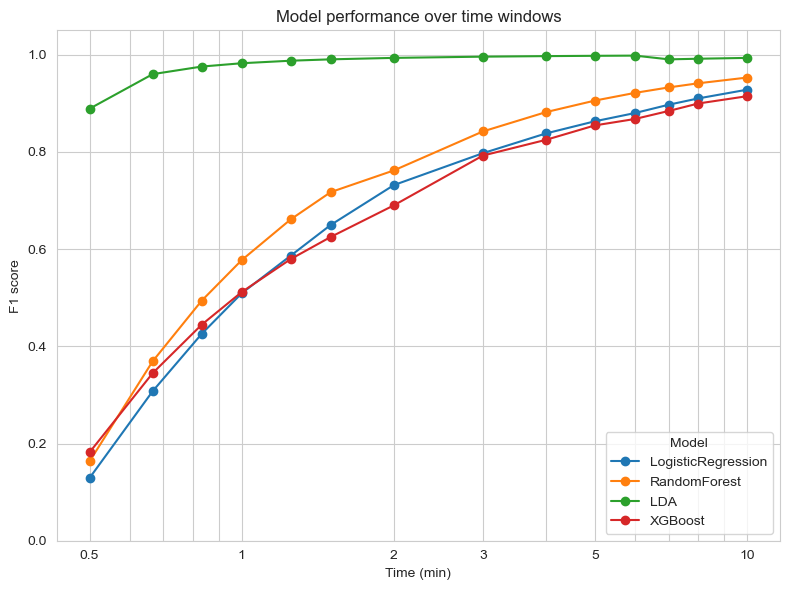

In [99]:
print("\nTesting on test subjects...")
df_test=pd.read_csv("test_features_c3005.csv")
df_test = df_test.dropna(axis=1, how="all")
time_sec=[30,40,50,60,75,90,120,180,240,300,360,420,480,600]
window_size_sec=30

f1_scores = {name: [] for name in models.keys()}

for t in time_sec:
    print(f"\n======= first {t/60} min =======")
    start = 1200 + t - window_size_sec + 1 
    mask = df_test["win_start_sec"] < start
    X_test = df_test[mask].drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0)
    y_test = df_test[mask]["label"].values.astype(int)

    test_results = {}

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            y_prob = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        y_pred = (y_prob >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)
        f1_scores[name].append(f1)

        test_results[name] = {"F1_test": f1, "AUC_PR_test": auc_pr,
                      "precision": precision, "recall": recall}

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, target_names=["Baseline", "TSST"]))

time_min = np.array(time_sec) / 60  # convert to minutes

plt.figure(figsize=(8, 6))
for name, f1_vals in f1_scores.items():
    plt.plot(time_min, f1_vals, marker='o', label=name)

plt.xscale("log")
plt.xlabel("Time (min)")
plt.ylabel("F1 score")
plt.title("Model performance over time windows")
plt.ylim(0, 1.05)
plt.grid(True,which="both")
plt.xticks([0.5,1,2,3,5,10],labels=["0.5","1","2","3","5","10"])
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Model training: 60s window and 5s shift

Here, we only use the training set: subject 2-13. Among these, we randomly select subjects 13 as hold-out subject for testing. 

The remaining subjects 2-12 are used to train models, with LOSO cross validation

Test subjects: 13

Running LOSO CV on training subjects...

Running LOSO CV on training subjects...


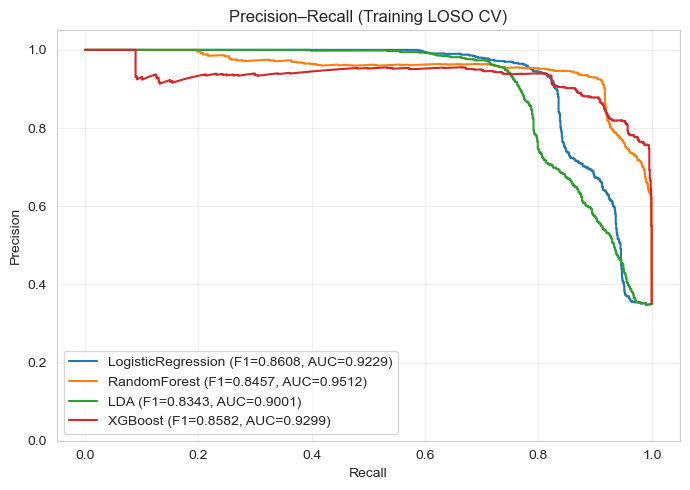

In [72]:
df = pd.read_csv("train_features_c6005.csv")
# Prepare for modeling 
X = df.drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0) # keeping only features
y = df["label"].values.astype(int)
groups = df["subject"].values

subject_ids = sorted(np.unique(groups))

# Train test split
random.seed(42)
test_subjects = random.sample(subject_ids, 1)
train_subjects = [s for s in subject_ids if s not in test_subjects]

print("Test subjects:", test_subjects[0])

# Masks
train_mask = np.isin(groups, train_subjects)
test_mask  = np.isin(groups, test_subjects)

X_train, y_train, groups_train = X[train_mask], y[train_mask], groups[train_mask]
X_test,  y_test,  groups_test  = X[test_mask],  y[test_mask],  groups[test_mask]

# LOSO CV on training subjects only
logo = LeaveOneGroupOut()
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=5000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=500, class_weight="balanced", max_depth=10, random_state=42),
    "LDA": LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"),
    "XGBoost": XGBClassifier(learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,reg_lambda=1.0,random_state=42,objective="binary:logistic")
}

print("\nRunning LOSO CV on training subjects...")
cv_results = {}
plt.figure(figsize=(7,5))
print("\nRunning LOSO CV on training subjects...")
for name, model in models.items():
    y_true_all, y_prob_all = [], []
    for tr, te in logo.split(X_train, y_train, groups_train):
        model.fit(X_train.iloc[tr], y_train[tr])
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_train.iloc[te])[:,1]
        else:
            y_prob = model.decision_function(X_train.iloc[te])
        y_true_all.extend(y_train[te])
        y_prob_all.extend(y_prob)

    y_true_all, y_prob_all = np.array(y_true_all), np.array(y_prob_all)
    precision, recall, _ = precision_recall_curve(y_true_all, y_prob_all)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_true_all, (y_prob_all >= 0.5).astype(int))
    cv_results[name] = {"F1_trainCV": f1, "AUC_PR_trainCV": auc_pr,
                        "precision": precision, "recall": recall}
    plt.plot(recall, precision, label=f"{name} (F1={f1:.4f}, AUC={auc_pr:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (Training LOSO CV)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.ylim(0,1.05)
plt.show()


## Test on subject 13


Testing on hold-out subjects...

======= first 1.25 min =======

=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00         4

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00         4

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00         4

    accuracy                           1.00       229


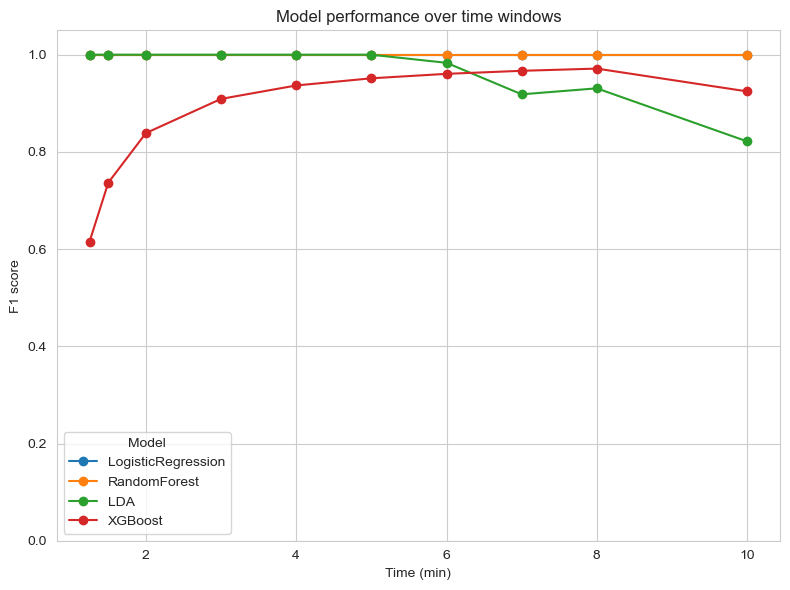

In [ ]:
print("\nTesting on hold-out subjects...")
time_sec=[75,90,120,180,240,300,360,420,480,600]
window_size_sec=60

f1_scores = {name: [] for name in models.keys()}

for t in time_sec:
    print(f"\n======= first {t/60} min =======")
    start = 1200 + t - window_size_sec + 1 
    mask = df["subject"].isin(test_subjects) & (df["win_start_sec"] < start)
    X_test = df[mask].drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0)
    y_test = df[mask]["label"].values.astype(int)

    test_results = {}

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            y_prob = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        y_pred = (y_prob >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)
        f1_scores[name].append(f1)

        test_results[name] = {"F1_test": f1, "AUC_PR_test": auc_pr,
                      "precision": precision, "recall": recall}

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, target_names=["Baseline", "TSST"]))

time_min = np.array(time_sec) / 60  # convert to minutes

plt.figure(figsize=(8, 6))
for name, f1_vals in f1_scores.items():
    plt.plot(time_min, f1_vals, marker='o', label=name)

plt.xlabel("Time (min)")
plt.ylabel("F1 score")
plt.title("Model performance over time windows")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## Test on test subjects

### ROC curve plots, not useful because of class imbalance


Testing on hold-out subjects...

=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.99      0.99       225
        TSST       0.70      1.00      0.82         7

    accuracy                           0.99       232
   macro avg       0.85      0.99      0.91       232
weighted avg       0.99      0.99      0.99       232


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       225
        TSST       0.44      1.00      0.61         7

    accuracy                           0.96       232
   macro avg       0.72      0.98      0.79       232
weighted avg       0.98      0.96      0.97       232


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00         7

    accuracy                           1.00       232
   macro avg       1.00      1.0

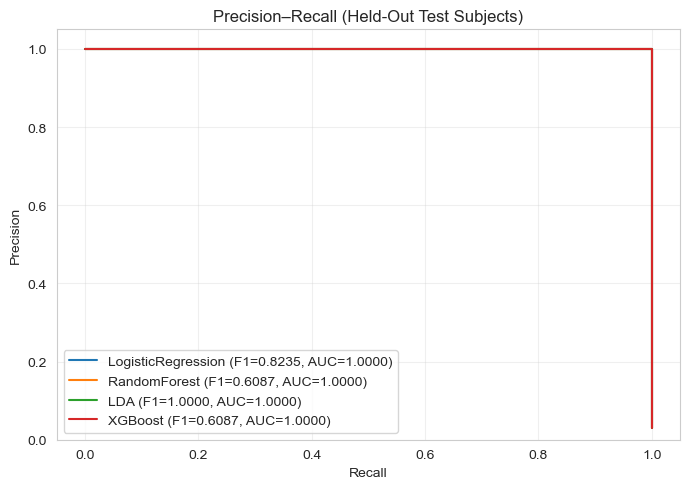


=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.99      0.99       225
        TSST       0.81      1.00      0.90        13

    accuracy                           0.99       238
   macro avg       0.91      0.99      0.94       238
weighted avg       0.99      0.99      0.99       238


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       225
        TSST       0.59      1.00      0.74        13

    accuracy                           0.96       238
   macro avg       0.80      0.98      0.86       238
weighted avg       0.98      0.96      0.97       238


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00        13

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted av

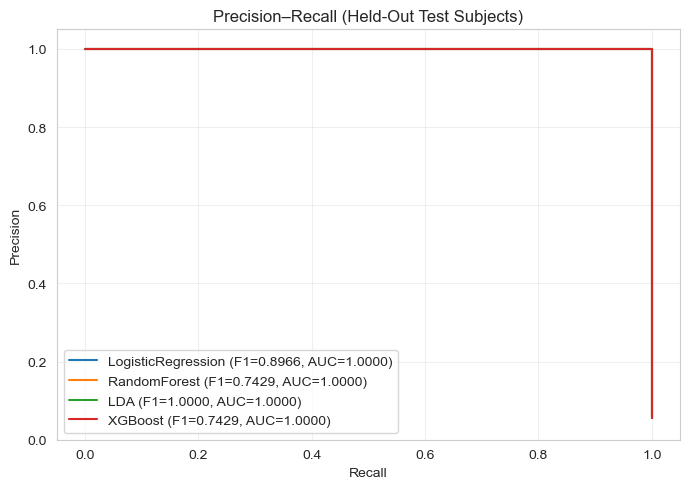


=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.99      0.99       225
        TSST       0.94      1.00      0.97        49

    accuracy                           0.99       274
   macro avg       0.97      0.99      0.98       274
weighted avg       0.99      0.99      0.99       274


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       225
        TSST       0.84      1.00      0.92        49

    accuracy                           0.97       274
   macro avg       0.92      0.98      0.95       274
weighted avg       0.97      0.97      0.97       274


=== LDA ===
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00       225
        TSST       1.00      1.00      1.00        49

    accuracy                           1.00       274
   macro avg       1.00      1.00      1.00       274
weighted av

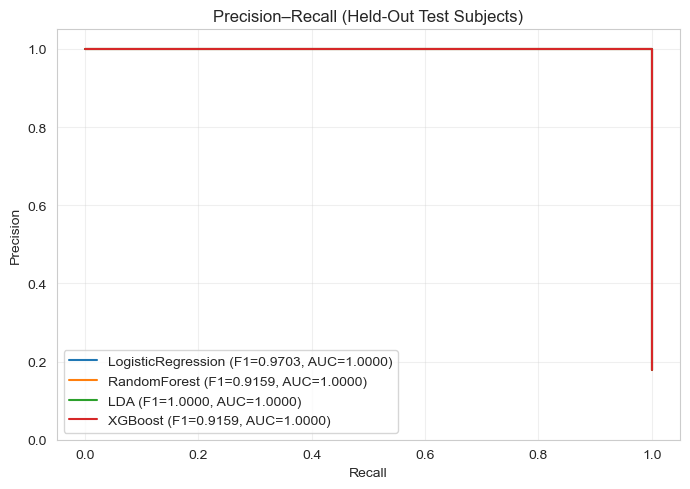


=== LogisticRegression ===
              precision    recall  f1-score   support

    Baseline       1.00      0.99      0.99       225
        TSST       0.97      1.00      0.99       109

    accuracy                           0.99       334
   macro avg       0.99      0.99      0.99       334
weighted avg       0.99      0.99      0.99       334


=== RandomForest ===
              precision    recall  f1-score   support

    Baseline       1.00      0.96      0.98       225
        TSST       0.92      1.00      0.96       109

    accuracy                           0.97       334
   macro avg       0.96      0.98      0.97       334
weighted avg       0.98      0.97      0.97       334


=== LDA ===
              precision    recall  f1-score   support

    Baseline       0.98      1.00      0.99       225
        TSST       1.00      0.96      0.98       109

    accuracy                           0.99       334
   macro avg       0.99      0.98      0.99       334
weighted av

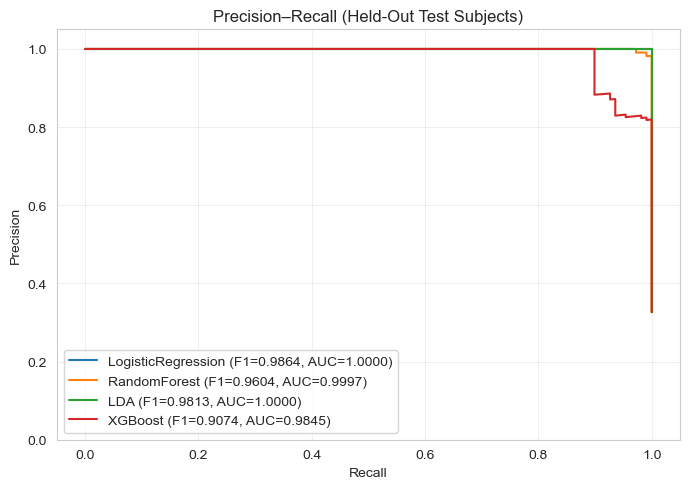

In [48]:
print("\nTesting on hold-out subjects...")
time_sec=[90,120,300,600]
window_size_sec=60

for t in time_sec:
    start = 1200 + t - window_size_sec + 1 
    mask = df["subject"].isin(test_subjects) & (df["win_start_sec"] < start)
    X_test = df[mask].drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0)
    y_test = df[mask]["label"].values.astype(int)

    test_results = {}
    plt.figure(figsize=(7,5))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            y_prob = model.decision_function(X_test)
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall, precision)
        f1 = f1_score(y_test, (y_prob >= 0.5).astype(int))
        test_results[name] = {"F1_test": f1, "AUC_PR_test": auc_pr,
                          "precision": precision, "recall": recall}
        plt.plot(recall, precision, label=f"{name} (F1={f1:.4f}, AUC={auc_pr:.4f})")

    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, target_names=["Baseline", "TSST"]))

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall (Held-Out Test Subjects)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.ylim(0,1.05)
    plt.show()

In [ ]:
print("\nTesting on test subjects...")
df_test=pd.read_csv("test_features_c6005.csv")
time_sec=[75,90,120,180,240,300,360,420,480,600]
window_size_sec=60

f1_scores = {name: [] for name in models.keys()}

for t in time_sec:
    print(f"\n======= first {t/60} min =======")
    start = 1200 + t - window_size_sec + 1 
    mask = df_test["win_start_sec"] < start
    X_test = df_test[mask].drop(columns=["label", "subject","win_start_sec"], errors="ignore").fillna(0.0)
    y_test = df_test[mask]["label"].values.astype(int)

    test_results = {}

    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)
        f1_scores[name].append(f1)

        test_results[name] = {"F1_test": f1, "AUC_PR_test": auc_pr,
                      "precision": precision, "recall": recall}

        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred, target_names=["Baseline", "TSST"]))

time_min = np.array(time_sec) / 60  # convert to minutes

plt.figure(figsize=(8, 6))
for name, f1_vals in f1_scores.items():
    plt.plot(time_min, f1_vals, marker='o', label=name)

plt.xlabel("Time (min)")
plt.ylabel("F1 score")
plt.title("Model performance over time windows")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()